In [195]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab08.ok')

Assignment: lab08
OK, version v1.13.11



# Lab 8: Regularization

In this lab, you will go through the practice of using regularization to reduce overfitting. 

### Due Date ###
The assignment is due on **Monday, April 13th at 11:59pm PST**.

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *I work alone.*

In [196]:
# Run this cell to set up your notebook
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from IPython.display import display, Latex, Markdown

In this lab, we will use the same dataset as in Lab 7. Run the following cell to load the data into a dataframe:

In [197]:
from sklearn.datasets import load_boston
boston_data = load_boston()
#print(boston_data['DESCR']) # Uncomment this line if you are interested in what the features are

boston = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Recall that in Lab 7, we started with a linear model using the full set of features from the `boston` dataframe, expanded the feature set by adding the square, square root, and hyperbolic tangent of every feature in the original dataframe, and used cross-validation to select the best first $N$ features from the expanded feature set. 

Please run the following cell to expand the feature set by adding the square, square root, and hyperbolic tangent of every feature in the original dataframe like we did in Lab 7. Now the feature matrix has 52 features.

In [198]:
boston_with_extra_features = boston.copy()
for feature_name in boston.columns:
    boston_with_extra_features[feature_name + "^2"] = boston_with_extra_features[feature_name] ** 2
    boston_with_extra_features["sqrt" + feature_name] = np.sqrt(boston_with_extra_features[feature_name])
    boston_with_extra_features["tanh" + feature_name] = np.tanh(boston_with_extra_features[feature_name])
    
boston_with_extra_features.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,tanhTAX,PTRATIO^2,sqrtPTRATIO,tanhPTRATIO,B^2,sqrtB,tanhB,LSTAT^2,sqrtLSTAT,tanhLSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,1.0,234.09,3.911521,1.0,157529.6100,19.922349,1.0,24.8004,2.231591,0.999905
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,1.0,316.84,4.219005,1.0,157529.6100,19.922349,1.0,83.5396,3.023243,1.000000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,1.0,316.84,4.219005,1.0,154315.4089,19.819939,1.0,16.2409,2.007486,0.999368
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,1.0,349.69,4.324350,1.0,155732.8369,19.865296,1.0,8.6436,1.714643,0.994426
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,1.0,349.69,4.324350,1.0,157529.6100,19.922349,1.0,28.4089,2.308679,0.999953


In [199]:
X = boston_with_extra_features
Y = boston_data['target']

However, recall from Lab 7 that when we plot the training and test error as we add each additional feature, our model begins to overfit. That is, even though the training error continues to decrease, the test error starts to increase. This is undesirable as the goal of machine learning is that our model should generalize well to unseen data.

In Lab 7, we used cross validation to find the best "first $N$" features. One drawback of this method is that we are not considering every subset of the features. In fact, we only compared the perfomance of models trained from 52 different feature sets. We can in theory use cross-validation on all possible subsets of the $52$ features, which will involving doing cross-validation on
$$2^{52} - 1 \approx 4.5 \times 10^{15}$$  
different feature sets, which can be computationally challenging.

Alteratively, we can use lasso regularization to perform automatic feature selection. And in general, we can use regularization to avoid overfitting. The idea of regularization is to penalize the weights $\theta$ corresponding to the features through some function $Reg(\theta)$ in the loss. Hence our objective is to compute the following:

$$
\hat{\theta} = \arg \min\limits_{\theta} \frac{1}{n}\sum\limits_{i=1}^{n} Loss(Y_i, f_{\theta}(X_i)) + \alpha Reg(\theta)
$$
where $\alpha$ is a hyperparameter. 

In the following questions we will examine two commonly used regularization functions ($d$ is the number of features used):

(1) Lasso: $\text{Reg}^{\text{lasso}}(\theta) = \sum_{i=1}^{d} |\theta_i|$

(2) Ridge: $\text{Reg}^{\text{ridge}}(\theta) = \sum_{i=1}^{d} \theta_i^2$

## Question 1

Before we fit a linear model with regularization, we need to first normalize our features. This is because if different features are on different magnitude scales, the magnitude of the corresponding weights for a good model may be very different. However, we penalize the weight for each feature equally in regularization. 

You can standardize a feature by computing: 
$$
z = \frac{x - \text{Mean}(x)}{\text{StdDev}(x)}
$$

In the cell below, complete the `normalize` function which returns the standardized version of input `data`. If $\text{StdDev}(x)$ is $0$ for a feature, fill in $0$'s for the standardized values for this feature.

<!--
BEGIN QUESTION
name: q1
-->

In [200]:
def normalize(data):
    '''
    Args:
        data : a dataframe
    Returns:
        the normalized version of input data with NAN values filled with 0's
    '''
    return ((data - data.mean()) / data.std()).fillna(0)

X_normalized = normalize(X)
X_normalized.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,tanhTAX,PTRATIO^2,sqrtPTRATIO,tanhPTRATIO,B^2,sqrtB,tanhB,LSTAT^2,sqrtLSTAT,tanhLSTAT
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,...,0.0,-1.456987,-1.452136,0.134676,0.525807,0.384010,0.046184,-0.788749,-1.201500,0.103427
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,...,0.0,-0.372709,-0.266657,0.178549,0.525807,0.384010,0.046184,-0.539919,-0.399557,0.128269
2,-0.416929,-0.487240,-0.592794,-0.272329,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,...,0.0,-0.372709,-0.266657,0.178549,0.448969,0.355550,0.046184,-0.825008,-1.428519,-0.037809
3,-0.416338,-0.487240,-1.305586,-0.272329,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,...,0.0,0.057726,0.139493,0.178788,0.482854,0.368155,0.046184,-0.857192,-1.725169,-1.337326
4,-0.412074,-0.487240,-1.305586,-0.272329,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,...,0.0,0.057726,0.139493,0.178788,0.525807,0.384010,0.046184,-0.773463,-1.123410,0.115936


In [201]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Note that we asked you to implement the normalize function yourself above to help you gain familiarity with what is means by normalizing the data. However, for the rest of the lab, we will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function from sklearn.

Now we will split the dataset into training set and test set. Then we compute the normalized version of them.

In [202]:
# Train & Test split
np.random.seed(41) # Do not change this line
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10)
X_train_normalized = StandardScaler().fit_transform(X_train)
X_test_normalized = StandardScaler().fit_transform(X_test)

## Ridge Regression


If we use ridge regression and assume our loss is $L_2$ loss, we solve the following optimization problem: 
$$
\hat{\theta} = \arg \min\limits_{\theta} \frac{1}{n}\sum\limits_{i=1}^{n} L_2(Y_i, f_{\theta}(X_i)) + \alpha \sum\limits_{k=1}^{d}\theta_k^2.
$$
where $\alpha$ is a nonnegative hyper-parameter. 

One nice thing about ridge linear regression with L-2 loss is that it admits a closed form solution even if $X^{\top}X$ is not full rank. The closed form solution is given by
$$
\hat{\theta} = (X^{\top}X + n\alpha I)^{-1}X^{\top}Y
$$
for the above optimization problem.

To evaluate model performance, we define RMSE in the following cell:

In [203]:
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X)) ** 2))

## Question 2a

Use `sklearn.linear_model.ridge` to fit ridge linear regression models and compute the RMSE using 
**5-fold** cross-validation. 

**Note: the data should be normalized after splitting the data in general.** For this question, to normalize the data, please use the function [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Please use this function in combination with [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), and function `rmse_score` defined previously to complete the code in the cell below. 

<!--
BEGIN QUESTION
name: q2a
-->

In [204]:
from sklearn.linear_model import Ridge

alpha = 0.1 # The regularization hyperparameter

# Initiate a model with the hyperparameter `alpha`
# Hint: the syntax should look like: Pipeline([("transformer", ..., ("LinearModel", ...)])
model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Ridge(alpha))])

# Evaluate the RMSE of the validation error
# Hint: Don't forget to take the mean!
validation_error = cross_val_score(model, X_train, Y_train, scoring = rmse_score, cv = 5).mean()


print("Validation RMSE:", validation_error)

Validation RMSE: 14.615491801879747


In [205]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Hyperparameter in Ridge Linear Regression

We just fitted models using ridge regression! However, our choice of hyperparameter seems rather arbitrary. 

In the following questions, we will experiment with different choices of $\alpha$ and look at the effect of different values of $\alpha$ on the weights. 

For your convenience, we define a function `ridge_alpha` which returns the weights $\theta$ of the fitted linear model given standardized data `X` and `y` with ridge regression and the RMSE on the input data.

In [206]:
def ridge_alpha(alpha, X, y):
    """
    Input:
        X - standardized feature matrix
        y - target vector
        alpha - regularization hyper-parameter
    Output:
        The tuple: (model_weights, rmse) where model_weights is d-dimensional array, each element 
        is rounded to the 3rd decimal. d is the dimension of each datapoint, or equivalently, the number 
        of features.
    """
    model = Ridge(alpha = alpha)
    model.fit(X, y)
    error = rmse_score(model, X, y)

    return (np.round(model.coef_, decimals = 3), error)

Let's first examine the output of ridge regression for extreme values of $\alpha$. 

To start, let's consider the case where $\alpha = 0$. In this case, the ridge linear regression objective function:
$$
\frac{1}{n}\sum\limits_{i=1}^{n} L_2(Y_i, f_{\theta}(X_i)) + \alpha \sum\limits_{i=1}^{d}\theta_k^2
$$
becomes
$$
\frac{1}{n}\sum\limits_{i=1}^{n} L_2(Y_i, f_{\theta}(X_i)),
$$
which is identical to the loss function for ordinary least squares. Hence, in this case, the linear model we fit will be identical to the one without regularization.

## Question 2b

### Question 2b(i)
Now let's consider the case where $\alpha$ is very large. In the cell below, compute the weights and RMSE of the ridge regression model when $\alpha = 10^{10}$.

<!--
BEGIN QUESTION
name: q2bi
-->

In [207]:
ridge_alpha_10e10_weights, ridge_alpha_10e10_rmse = ridge_alpha(10**10, X, Y)
print("weights:", ridge_alpha_10e10_weights)
print("RMSE:", ridge_alpha_10e10_rmse)

weights: [-0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0.
  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0.]
RMSE: 7.945576175109449


In [208]:
ok.grade("q2bi");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2b(ii)

What do you observe from the result above? Justify your observation. Write your answers in the cell below:

<!--
BEGIN QUESTION
name: q2bii
-->

**A large alpha makes the model does not fit very well. Increasing the alpha value will make the error to go up and validation error to go up slightly which suggest the model starts to underfit as we increase the alpha.**

## Question 2c 

In the cell below, compute the **5-fold** cross validation error using the sklearn functionalities introduced in lecture for all the values in `alpha_arr`. Then find the $\alpha$ with the smallest cross-validation error.

<!--
BEGIN QUESTION
name: q2c
-->

In [209]:
alpha_arr = np.linspace(0.02, 0.5, 60)
cv_errors = []

# Hint: This should be very similar to what you did in 2a.

model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Ridge(alpha))])

for alpha in alpha_arr:
    model.set_params(LinearModel__alpha=alpha)
        
    # compute the cross validation error
    cv_error = cross_val_score(model, X_train, Y_train, scoring = rmse_score, cv = 5).mean()
    
    cv_errors.append(cv_error)
    
best_alpha_ridge = alpha_arr[np.argmin(cv_errors)]

print(f"The best alpha value is {best_alpha_ridge}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

The best alpha value is 0.15830508474576271
Cross validation error for the best alpha value is 14.481714562577206


In [210]:
ok.grade("q2c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Question 2d
In the cell below, plot the cross validation errors for different values of $\alpha$ for ridge regression. The x-axis should be $\alpha$ and y-axis should be the cross validation error.

<!--
BEGIN QUESTION
name: q2d
-->

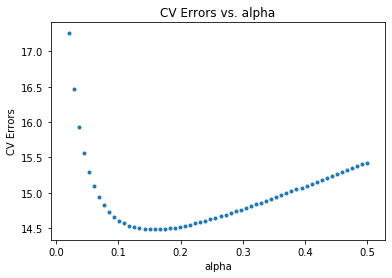

In [211]:
plt.scatter(x = alpha_arr, y = cv_errors, marker = '.')
plt.xlabel('alpha')
plt.ylabel('CV Errors')
plt.title('CV Errors vs. alpha')
plt.show()

What do you observe from the plot above? Write your answer in the cell below.

**The CV Errors vs. alpha graph looks like a skewed parabola. If we use a very small value of alpha or a large value of alpha, then the errors will increase. Thus, there is a best alpha value with the smallest cv error.**

## Lasso Regression

If we use lasso regression and assume our loss is $L_2$ loss, we solve the following optimization problem: 

$$
\hat{\theta} = \arg \min\limits_{\theta} \frac{1}{n}\sum\limits_{i=1}^{n} L_2(Y_i, f_{\theta}(X_i)) + \alpha \sum\limits_{k=1}^{d}|\theta_k|.
$$

One nice thing about lasso regression is that we can use it to select features because optimized weights for lasso regression are sparse, i.e., many of the weights are $0$'s. For more details on why this is true, please refer to Lecture 19. 

<img src="lasso.png" width=500px>

You can inspect the weights of a fitted lasso linear regression model in the cell below.

In [212]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 1)
model.fit(X_train_normalized, Y_train)
model.coef_

array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  1.89814435e-04,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  9.58388276e-02,  2.49861182e-16,
        1.24930591e-16, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.81742915e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.00827425e+00, -0.00000000e+00,  0.00000000e+00,  2.33415288e-01,
        0.00000000e+00, -0.00000000e+00, -4.09722458e+00, -2.25533411e-02])

In comparison, the weights of a fitted ridge linear regression model looks like:

In [213]:
model = Ridge(alpha = 1)
model.fit(X_train_normalized, Y_train)
model.coef_

array([-2.26302901e+00, -2.06272043e+00,  1.11764381e+00,  1.38970319e-01,
       -7.95402029e-01, -5.74045140e-01, -2.70520013e-01, -1.91484640e+00,
        7.44555761e-01, -3.65231594e-01, -9.75774607e-01,  2.28463264e+00,
        2.26263963e-01,  1.68717462e+00, -2.30814156e+00,  1.46007305e+00,
        2.48199791e+00, -2.14749594e+00,  2.01041940e+00, -4.66948027e-02,
       -1.50857443e+00, -3.45536581e-01,  1.38970319e-01,  1.38970319e-01,
        1.38970319e-01, -2.52626196e+00,  4.85999267e-01,  2.72109452e-01,
        8.74126822e+00, -5.37435186e+00,  3.72344988e-03, -2.13791478e-01,
        7.16080895e-02,  1.80952178e-01,  3.08785667e-01, -2.00700353e-01,
       -2.42642002e+00,  1.13107008e+00,  9.20301467e-01,  3.93556792e-01,
        1.72867532e+00, -3.04877972e+00,  0.00000000e+00,  1.80178413e+00,
       -2.42001210e+00,  5.92677955e-02, -1.91213877e+00, -9.27715887e-04,
        3.07779127e-02,  6.54127461e-01, -5.05208413e+00, -4.66420136e-01])

### Hyperparameter in Lasso Linear Regression

Similar to ridge regression, as $\alpha$ goes to zero, lasso regression becomes identical to ordinary linear regression without regularization; as $\alpha$ goes to infinity, all the fitted weights become zero.  

## Question 3
Just like what we did for ridge regression, we need to tune the hyperparameter $\alpha$ to find the best $\alpha$ for lasso regression. In the cell below, use **5-fold** cross validation to find the optimal parameter $\alpha$.

**Note: When initiating your Lasso Linear Regression model, put `max_iter = 1000000` as an argument to `Lasso()`. The reason behind this is that for small regularization parameters, the Lasso Linear Regularization solver takes more iterations to converge.**

<!--
BEGIN QUESTION
name: q3
-->

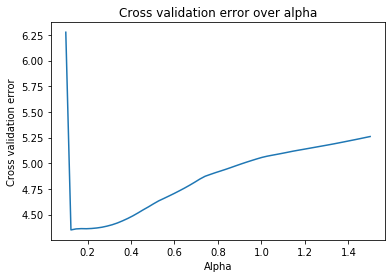

The best alpha value is 0.12372881355932204
Cross validation error for the best alpha value is 4.350384165146851


In [214]:
alpha_arr = np.linspace(0.1, 1.5, 60)
cv_errors = []
model = Pipeline([("transformer", StandardScaler()), 
                  ("LinearModel", Lasso(alpha, max_iter = 1000000))
                 ])

for alpha in alpha_arr:
    model.set_params(LinearModel__alpha=alpha)

    # compute the cross validation error
    cv_error = cross_val_score(model, X_train, Y_train, scoring = rmse_score, cv = 5).mean()
    
    cv_errors.append(cv_error)
    
best_alpha_lasso = alpha_arr[np.argmin(cv_errors)]

plt.plot(alpha_arr, cv_errors)
plt.title('Cross validation error over alpha')
plt.xlabel('Alpha')
plt.ylabel('Cross validation error')
plt.show()

print(f"The best alpha value is {best_alpha_lasso}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

In [215]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Question 4
In the previous questions, we have used cross validation to select the best $\alpha$'s for ridge regression and lasso regression. Based on this, select the best model with the smallest cross validation error out of all the models and hyperparameters we have considered (either lasso regression with its best $\alpha$ or ridge regression with its best $\alpha$). Train this model using the **entire training set** and evaluate the performance of the model on the test set.

**Note: If you are using Lasso for your final model, put `max_iter = 1000000` as an argument to `Lasso()`. The reason behind this is that for small regularization parameters, the Lasso Linear Regularization solver takes more iterations to converge.**

<!--
BEGIN QUESTION
name: q4
-->

In [216]:
final_model = Lasso(alpha = best_alpha_lasso, max_iter = 1000000)

# Fit `final_model`
final_model.fit(X_train_normalized, Y_train)

# Error of prediction
test_RMSE = rmse_score(final_model, X_test_normalized, Y_test)


print('test RMSE:', test_RMSE)

test RMSE: 4.994121608671193


In [217]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Submission

Congratulations! You are finished with this assignment. Please don't forget to submit by 11:59pm PST on Monday, 04/13!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [ ]:
# Save your notebook first, then run this cell to submit.
ok.submit()